# **Task:- Forecasting the behaviour of Stock Price using LSTM.**

**Dataset:-** https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231



In [0]:
# Importing the libraries
import math
import numpy as np
import pandas as pd
from numpy import newaxis
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Keras imports
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Ignore Warning
import warnings
warnings.filterwarnings("ignore") # ignore messy numpy warnings

# **Dataset**

In [0]:
# Reading the dataset

df=pd.read_csv('drive/My Drive/IBM.csv',index_col="Date",parse_dates=True)

In [6]:
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


# **Data Plotting**

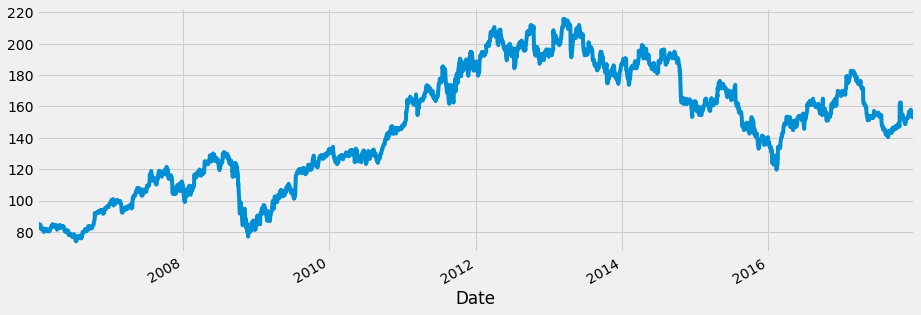

In [7]:
# Plotting the dataset
df['High'].plot(figsize=(14,5));

# **Pre-Paring Data for LSTM model**

In [0]:
# Dataset Prepair 
def load_data(datasetname, column, seq_len, normalise_window):
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
      result.append(data[index: index + sequence_length])


    #Normalization
    
    if normalise_window:
      result = normalise_windows(result)
    result = np.array(result)

    # Test and Train Split

    noobs = round(0.9 * result.shape[0]) 
    train = result[:int(noobs), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(noobs):, :-1]
    y_test = result[int(noobs):, -1] 

    # Train Test data preparation
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    return [x_train, y_train, x_test, y_test]    

# **Normalization Function**

In [0]:
# Normalize window
def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

## **1 Step Prediction. Shifting window size by 1.** 

In [0]:
# Predict Full Sequence
	def predict_sequence_full(model, data, window_size):
		#Shift the window by 1 new prediction each time, re-run predictions on new window
		
		curr_frame = data[0]
		predicted = []
		for i in range(len(data)):
			predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
			curr_frame = curr_frame[1:]
			curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
		return predicted

# **Multiple Step Shifting.**

In [0]:
# Predicting Multiple Sequences
def predict_sequences_multiple(model, data, window_size, prediction_len):
		#Predict sequence of 50 steps before shifting prediction run forward by 50 steps
		
		prediction_seqs = []
		for i in range(int(len(data)/prediction_len)):
			curr_frame = data[i*prediction_len]
			predicted = []
			for j in range(prediction_len):
				predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
				curr_frame = curr_frame[1:]
				curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
			prediction_seqs.append(predicted)
		return prediction_seqs

In [0]:
# Plotting
def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 

In [0]:
# Plotting the multiple data
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

## **Method for Model Evaluation.**

In [0]:
# Evaluation
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

# **Creating  the Feature :- Train and Test**

In [0]:
Enrol_window = 100
feature_train, label_train, feature_test, label_test = load_data(df, 'High', Enrol_window, True)

# **Plotting the Train and Test Data**

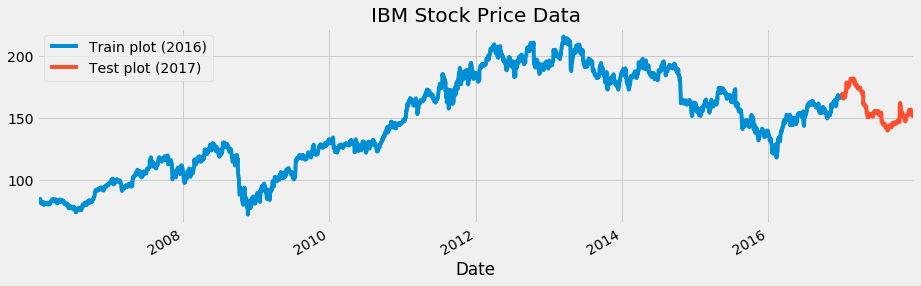

In [16]:
# Train Test Plot
plt.title("IBM Stock Price Data")
df["Close"][:'2016'].plot(figsize=(14,4),legend=True)
df["Close"]['2017':].plot(figsize=(14,4),legend=True);
plt.legend(['Train plot (2016)','Test plot (2017)'])
plt.show()

# **LSTM Model Architecture**

In [0]:
# The LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Third LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Fourth LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

# Compiling 
model.compile(optimizer='adam',loss='mean_squared_error')


## **Fitting the LSTM model**

In [0]:
#Train the model
model.fit(feature_train, label_train, batch_size=32, epochs=20, validation_data = (feature_test, label_test))

# **Forecating the value and Plotting** 

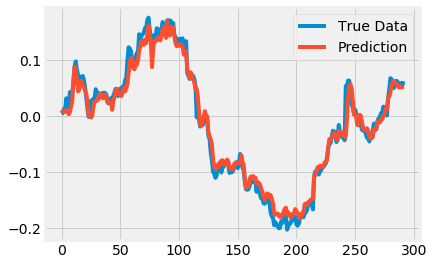

In [20]:
# Forecasting the values
predicted_stock_price = model.predict(feature_test)

# Plotting the graph between True data and Forecasted value
plot_results(predicted_stock_price,label_test)

# **Multiple Step ahead prediction i.e. 50**

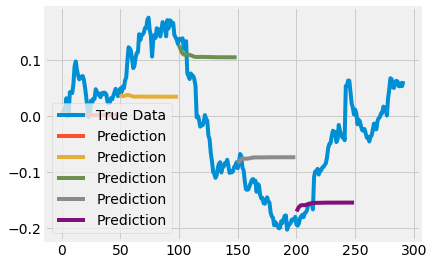

In [21]:
# Multiple Sequence Prediction
# Predict sequence of 50 steps before shifting prediction run forward by 50 steps

predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 50)

# Plotting the graph 
plot_results_multiple(predictions, label_test, 50)  

# **Evaluate the Model RMSE**

In [22]:
# Evaluation of model RMSE
return_rmse(label_test,predicted_stock_price)

The root mean squared error is 0.014667049958875309.


In [0]:
data_set = df.iloc[:,1:2].values

In [0]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(data_set)

# **Inverse Transformation of Predicted Data**

In [31]:
Predicted_original = sc.inverse_transform(predicted_stock_price)
len(Predicted_original)

292

# **Model Saving in JASON form**

In [0]:
# serialize model to JSON
model_json = model.to_json()

In [0]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [29]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# <center>**Thank You!**</center>